In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

## Happiness and Marriage

The function to simulate data is a modified version of the function in: https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_06.ipynb

In [2]:
def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=1000, seed=1234):
    np.random.seed(seed)

    population = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    population.loc[:, "age"] = np.repeat(np.arange(1, 66), 20)
    population.loc[:, "happiness"] = np.tile(np.linspace(-2, 2, 20), 65)

    for i in range(N_years):
        # age population
        population.loc[:, "age"] += 1
        
        # replace old folk with new folk
        idx = population.age > 65
        population.loc[idx, "age"] = 1
        population.loc[idx, "married"] = 0
        population.loc[idx, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        eligible = (population.married == 0) & (population.age >= 18)
        marriage_prob = sigmoid(population.loc[eligible, "happiness"] - 4.0)
        will_marry = np.random.binomial(n=1, p=marriage_prob)
        population.loc[eligible, "married"] = will_marry

    population.sort_values("age", inplace=True, ignore_index=True)

    return population


### Code 6.21

In [3]:
df = sim_happiness(N_years=1000)
df.describe([0.055, 0.945])

,age,happiness,married
count,1300.000000,1.300000e+03,1300.000000
mean,33.000000,-1.004325e-16,0.286923
std,18.768883,1.214421e+00,0.452499
min,1.000000,-2.000000e+00,0.000000
5.5%,4.000000,-1.789474e+00,0.000000
50%,33.000000,-1.110223e-16,0.000000
94.5%,62.000000,1.789474e+00,1.000000
max,65.000000,2.000000e+00,1.000000


### Figure 6.4

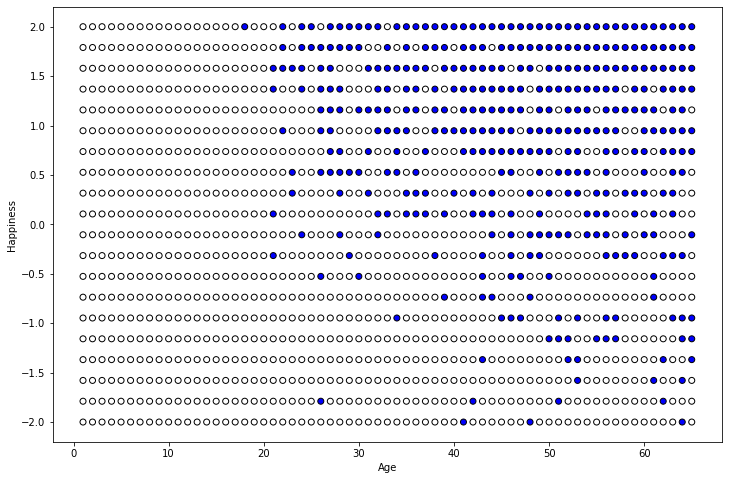

In [4]:
fig, ax = plt.subplots(figsize=[12, 8])
colors = np.where(df['married'] == 1, 'b', 'w')
ax.scatter(df['age'], df['happiness'], edgecolor='k', color=colors)

ax.set_xlabel('Age')
ax.set_ylabel('Happiness')

plt.show()

In [5]:
df['not_married'] = np.where(df['married'] == 1, 0, 1)

df_2 = df[df['age'] >= 18].copy()
df_2['A'] = (df_2['age'] - 18) / (65 - 18)

## The Model

$$
\begin{array}
    \text{happiness}            & \sim N(\mu, \sigma) \\
    \mu                         & \sim \alpha_{\text{married}} + \alpha_{\text{not married}} + \beta_{A} \cdot A \\
    \sigma                      & \sim \text{Exponential}(1) \\                                                     
    \alpha_{\text{married}}     & \sim N(0, 2) \\
    \alpha_{\text{not married}} & \sim N(0, 2) \\
    \beta_{A}                   & \sim N(0, 1) \\
\end{array}
$$